In [3]:
import numpy as np
import netCDF4 as nc
import h5py
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import seaborn as sns
import matplotlib as mpl
import cv2
import numpy as np

# General

### Load Model Data

In [4]:
datapath = './data.nosync/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.U850.19200101-20051231.nc'
dataset = nc.Dataset(datapath)

U850_period_interest = dataset['U850'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20060101)]
date_period_interest = dataset['date'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20060101)]
lon_model = dataset['lon'][:]
lat_model = dataset['lat'][:]

### Load Real Cyclons
(georeferenced)

In [4]:
hf.keys()

<KeysViewHDF5 ['images', 'lat_max', 'lat_min', 'lon_max', 'lon_min', 'time']>

In [20]:
first_cyclon = {key: hf[key][100] for key in hf.keys()}

In [21]:
first_cyclon['images'].shape

(3, 120, 120)

### Visual Confrontation

**NOTA IMPORTANTE**: i dati reali sono messi del tipo LAT-LON, mentre i dati del modello sono LON-LAT.

In [22]:
FIRST_CYCLON_MODEL = U850_period_interest[100][
    np.where(np.isclose(lon_model, first_cyclon['lon_min'], 1e-1))[0][0]:np.
    where(np.isclose(lon_model, first_cyclon['lon_max'], 1e-1))[0][0],
    np.where(np.isclose(lat_model, first_cyclon['lat_min'], 1e-1))[0][0]:np.
    where(np.isclose(lat_model, first_cyclon['lat_max'], 1e-1))[0][0]]

In [34]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(9, 6))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot "+str(first_cyclon['time'].astype("<M8[us]")))
ax.set_global()
mm = ax.pcolormesh(np.linspace(first_cyclon['lon_min'],
                               first_cyclon['lon_max'], 120),
                   np.linspace(first_cyclon['lat_min'],
                               first_cyclon['lat_max'], 120),
                   np.transpose(first_cyclon['images'][0]),
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.cool)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

NameError: name 'ccrs' is not defined

<Figure size 648x432 with 0 Axes>

In [47]:
FIRST_CYCLON_MODEL.shape

(27, 32)

In [24]:


# img = cv2.imread('images/U850_2005-01-01T12:00:00.000000.jpg')

res = cv2.resize(np.transpose(FIRST_CYCLON_MODEL), dsize=(120, 120), interpolation=cv2.INTER_CUBIC)

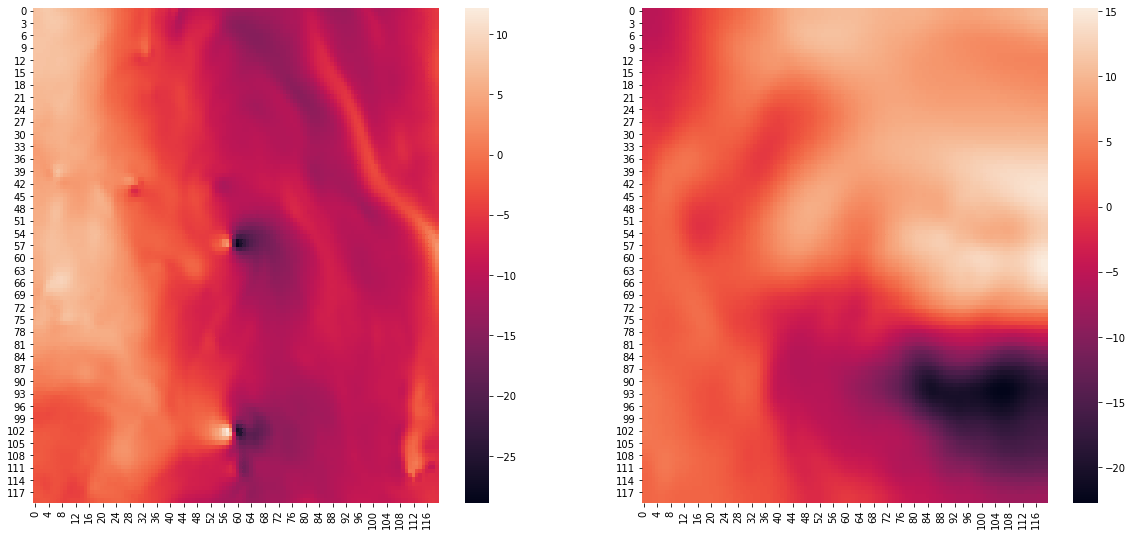

In [25]:
plt.figure(figsize=(20, 20))
plt.subplot(221)
sns.heatmap(np.transpose(first_cyclon['images'][0]))
# plt.savefig('images/real_cyclon_test.png')
# plt.close()
plt.subplot(222)
sns.heatmap(np.transpose(res))
# plt.savefig('images/model_cyclon_test.png')
# plt.close()
plt.show()

In [84]:
from PIL import Image
from glob import glob

size = 120,120
for inline in glob("images/*.png"):
    im = Image.open(inline)
    im.thumbnail(size, Image.ANTIALIAS)
    im.save(inline.split(".")[0]+"_resize.png", "PNG")

In [ ]:
    im = Image.open(inline) for inline in glob("images/*_resize.png"):


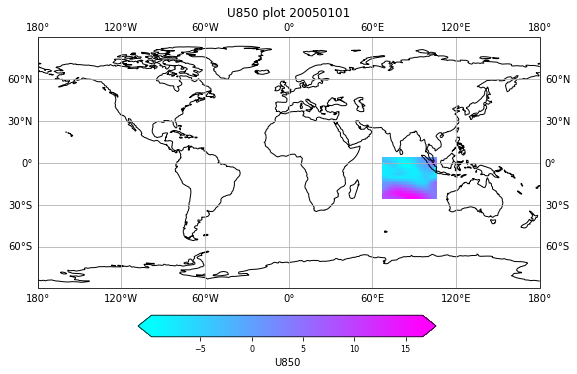

In [68]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(9, 6))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot "+str(date_period_interest[0]))
ax.set_global()
mm = ax.pcolormesh(np.linspace(first_cyclon['lon_min'],
                               first_cyclon['lon_max'], 32),
                   np.linspace(first_cyclon['lat_min'],
                               first_cyclon['lat_max'], 27),
                   (FIRST_CYCLON_MODEL),
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.cool)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

# Classification

In [10]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate


In [11]:
# this way I do not have to reshape the data
from keras.backend import set_image_data_format, image_data_format
from tensorflow.compat.v1 import disable_eager_execution
from tensorflow import executing_eagerly
from tensorflow.python.compiler.mlcompute import mlcompute

set_image_data_format('channels_first')
assert image_data_format() == 'channels_first', "Plase set keras backend as channels first."

# APPLE SPECIFIC IMPLEMENTATION
disable_eager_execution()
assert executing_eagerly() is False, "Please do not set to eager execution for this program."

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
mlcompute.set_mlc_device(device_name='cpu')  # Available options are 'cpu', 'gpu', and 'any'.

### Testing on real Images

In [6]:
images = hf['images'][()]

In [7]:
# images = np.expand_dims(images[2], axis = 0)
images = images[100:101]

In [8]:
images = np.expand_dims(images[:,0,:,:], axis = 1)

In [12]:
new_input = Input(shape=images.shape[1:])
img_conc = Concatenate(axis = 1)([new_input, new_input, new_input])  
VGG_model = VGG16(include_top=False, input_tensor=img_conc)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

In [137]:
new_input = Input(shape=images.shape[1:])
VGG_model = VGG16(include_top=False, input_tensor=new_input)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

In [147]:
main_model = load_model("./main_model_2")

In [13]:
U850_model = load_model("./model_just_850")

In [14]:
# test = preprocess_input(x = images)
test = images

In [15]:
test.shape

(1, 1, 120, 120)

In [16]:
test = base_model.predict(test)

/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [18]:
U850_model.evaluate(x = test, y = np.zeros(images.shape[0])+1)

[0.17735923826694489, 1.0]

In [17]:
main_model.evaluate(x = test, y = np.zeros(images.shape[0])+1)

NameError: name 'main_model' is not defined

**Notice**: this data is sightly different from the one used to train (the cyclon may be off-centered in the train image), but it is nonetheless from the same collection.

### Testing on model-generated images

We use for testing the second element in the cyclon list.

In [51]:
from datetime import datetime

In [58]:
real_times = hf['time'][2].astype("<M8[us]")
real_data = np.expand_dims(hf['images'][2], axis = 0)

In [26]:
FIRST_CYCLON_MODEL = U850_period_interest[100][
    np.where(np.isclose(lon_model, first_cyclon['lon_min'], 1e-1))[0][0]:np.
    where(np.isclose(lon_model, first_cyclon['lon_max'], 1e-1))[0][0],
    np.where(np.isclose(lat_model, first_cyclon['lat_min'], 1e-1))[0][0]:np.
    where(np.isclose(lat_model, first_cyclon['lat_max'], 1e-1))[0][0]]

In [27]:
FIRST_CYCLON_MODEL = cv2.resize(np.transpose(FIRST_CYCLON_MODEL), dsize=(120, 120), interpolation=cv2.INTER_CUBIC)

In [28]:
FIRST_CYCLON_MODEL = np.expand_dims(FIRST_CYCLON_MODEL, axis = [0,1])

In [29]:
FIRST_CYCLON_MODEL = base_model.predict(FIRST_CYCLON_MODEL)
U850_model.evaluate(x = FIRST_CYCLON_MODEL, y = [1])
# main_model.evaluate(x = FIRST_CYCLON_MODEL, y = [1])

[1.3830057382583618, 0.0]

In [103]:
main_model.predict(FIRST_CYCLON_MODEL)

array([[0.6147242]], dtype=float32)

In [4]:
U850_period_interest.shape

(365, 192, 288)

In [ ]:
import cv2
import numpy as np

# img = cv2.imread('images/U850_2005-01-01T12:00:00.000000.jpg')

res = cv2.resize(np.transpose(FIRST_CYCLON_MODEL), dsize=(120, 120), interpolation=cv2.INTER_CUBIC)

In [ ]:
FIRST_CYCLON_MODEL = [
    row[
    np.where(np.isclose(lon_model, first_cyclon['lon_min'], 1e-1))[0][0]:np.
    where(np.isclose(lon_model, first_cyclon['lon_max'], 1e-1))[0][0],
    np.where(np.isclose(lat_model, first_cyclon['lat_min'], 1e-1))[0][0]:np.
    where(np.isclose(lat_model, first_cyclon['lat_max'], 1e-1))[0][0]] for row in U850_period_interest]

In [ ]:
new_input = Input(shape=images.shape[1:])
VGG_model = VGG16(include_top=False, input_tensor=new_input)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)